In [12]:
%matplotlib inline

from scipy import interpolate
import numpy as np
import cgs as cgs
import dwarf_model as dw_model
from initial_conditions import ic_list as icl ;
from matplotlib import rc
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import sys
from __future__ import print_function

In [2]:
carina = icl.ic_object_dict['CarinaMidMed']

carina_orbit = np.genfromtxt("./../orbits/carina_orbit_tab.dat")
t_orbit = carina_orbit[:,0] * cgs.Myr
v_orbit = carina_orbit[:,2] * 1.0E5
rho_halo = carina.ic['n_halo'] * cgs.mp * carina.ic['mu_halo']

anal_carina = dw_model.analytical_dwarf('CarinaMidMed',carina.ic)
anal_carina.setup_orbit(t_orbit,rho_halo,v_orbit)

In [3]:
anal_carina.ic

{'M200': 6.74000417704841e+41,
 'M_DM': 7.3596700000000005e+40,
 'RM': 1.3056121310209298e+21,
 'T_dwarf': 10000.0,
 'T_halo': 1800000.0,
 'b': 2.4531136761000005e+21,
 'c': 17.753195173656437,
 'mu_dwarf': 1.297,
 'mu_halo': 0.62,
 'n_halo': 0.00017,
 'n_o': 0.544,
 'potential_type': 'NFW',
 'r_DM': 2.6845394946e+21,
 'r_s': 2.4531136761000005e+21,
 'rho_crit': 9.74e-30}

In [4]:
fpath="/home/emerick/Research/dwarfs/flash_runs/"
adiabatic = np.genfromtxt(fpath + "carina_adiabatic/carina_adiabatic_mass_dt5Myr.dat",names=True)
adiabatic['t'] = adiabatic['t'] * cgs.Myr
adiabatic['m'] = adiabatic['m'] * cgs.Msun

In [5]:

def function_to_fit(x, p0, p1, dwarf, method):

    def _mass_function(a,b,t,d,m):
        M_fit, R_fit = d.evolve(t, ['RPS','KH'],
                                   physics_kwargs={'RPS':{'alpha':a,'beta':b, 'method':m,
                                                                          'T_galaxy':d.ic['T_dwarf'],
                                                                          'mu_galaxy':d.ic['mu_dwarf']}})
        return M_fit
    # parameters for fit
    alpha = p0
    beta  = p1

    t = np.linspace(0.0,np.max(t_orbit)/cgs.Myr,1000.0)*cgs.Myr
    # evolve to get m as function of time
    m = _mass_function(alpha,beta,t,dwarf,method)
    
    # recast as callable function
    function = interpolate.UnivariateSpline(t, m,k=3)
    
    return function(x)

In [6]:
#func = lambda x,alpha,beta: function_to_fit(x,alpha,beta,anal_carina,method='shock')

#popt, pconv = curve_fit(func, adiabatic['m'], adiabatic['t'], p0=[0.75,25.0])

In [33]:
# time to do some manual fitting
alphas = np.linspace(0.9,1.2,40)
betas  = np.linspace(0.1,1.0,40)

In [34]:
%%capture --no-stderr

nparams = np.size(alphas)*np.size(betas)
error  = np.zeros(nparams)
params = np.array([[0.,0.]]*nparams)*1.0
i=0
for a in alphas:
    for b in betas:
        m = function_to_fit(adiabatic['t'],a,b,anal_carina,method='shock');
        
        error[i] = np.sum((m - adiabatic['m'])**2)
        
        params[i][0] = a * 1.0 
        params[i][1] = b * 1.0
        print('%i of %i - alpha = %.3f , beta = %.3f, error = %.5e'%(i+1,nparams,a,b,error[i]),file=sys.stderr)
        i = i + 1
        
        
params = np.array(params)


1 of 1600 - alpha = 0.900 , beta = 0.100, error = 3.07316e+77
2 of 1600 - alpha = 0.900 , beta = 0.123, error = 3.28801e+77
3 of 1600 - alpha = 0.900 , beta = 0.146, error = 5.10946e+77
4 of 1600 - alpha = 0.900 , beta = 0.169, error = 8.19288e+77
5 of 1600 - alpha = 0.900 , beta = 0.192, error = 1.21539e+78
6 of 1600 - alpha = 0.900 , beta = 0.215, error = 1.66020e+78
7 of 1600 - alpha = 0.900 , beta = 0.238, error = 2.10359e+78
8 of 1600 - alpha = 0.900 , beta = 0.262, error = 2.49315e+78
9 of 1600 - alpha = 0.900 , beta = 0.285, error = 2.84810e+78
10 of 1600 - alpha = 0.900 , beta = 0.308, error = 3.14918e+78
11 of 1600 - alpha = 0.900 , beta = 0.331, error = 3.36015e+78
12 of 1600 - alpha = 0.900 , beta = 0.354, error = 3.47915e+78
13 of 1600 - alpha = 0.900 , beta = 0.377, error = 3.50926e+78
14 of 1600 - alpha = 0.900 , beta = 0.400, error = 3.49869e+78
15 of 1600 - alpha = 0.900 , beta = 0.423, error = 3.50981e+78
16 of 1600 - alpha = 0.900 , beta = 0.446, error = 3.51664e+78
1

In [36]:
print(np.argmin(error), np.min(error) , np.median(error))
print(params[np.argmin(error)])

min_err_index = np.argmin(error)
best_alpha = params[min_err_index][0]
best_beta  = params[min_err_index][1]
string = "best alpha  = %.4f - best beta = %.4f\n"%(best_alpha,best_beta)
print(string)
outfile = open('outfile.dat','w')
outfile.write('shock\n')
outfile.write(string)

321 2.65050526401e+77 9.02858839319e+77
[ 0.96153846  0.12307692]
best alpha  = 0.9615 - best beta = 0.1231



In [37]:
%%capture --no-stderr

nparams = np.size(alphas)*np.size(betas)
sound_error  = np.zeros(nparams)
sound_params = np.array([[0.,0.]]*nparams)*1.0
i=0
for a in alphas:
    for b in betas:
        m = function_to_fit(adiabatic['t'],a,b,anal_carina,method='sound');
        
        sound_error[i] = np.sum((m - adiabatic['m'])**2)
        
        sound_params[i][0] = a * 1.0 
        sound_params[i][1] = b * 1.0
        print('%i of %i - alpha = %.3f , beta = %.3f, error = %.5e'%(i+1,nparams,a,b,sound_error[i]),file=sys.stderr)
        i = i + 1
        
sound_params = np.array(sound_params)


1 of 1600 - alpha = 0.900 , beta = 0.100, error = 3.53751e+78
2 of 1600 - alpha = 0.900 , beta = 0.123, error = 3.55087e+78
3 of 1600 - alpha = 0.900 , beta = 0.146, error = 3.56927e+78
4 of 1600 - alpha = 0.900 , beta = 0.169, error = 3.57312e+78
5 of 1600 - alpha = 0.900 , beta = 0.192, error = 3.59140e+78
6 of 1600 - alpha = 0.900 , beta = 0.215, error = 3.61252e+78
7 of 1600 - alpha = 0.900 , beta = 0.238, error = 3.61340e+78
8 of 1600 - alpha = 0.900 , beta = 0.262, error = 3.61540e+78
9 of 1600 - alpha = 0.900 , beta = 0.285, error = 3.60335e+78
10 of 1600 - alpha = 0.900 , beta = 0.308, error = 3.66021e+78
11 of 1600 - alpha = 0.900 , beta = 0.331, error = 3.65391e+78
12 of 1600 - alpha = 0.900 , beta = 0.354, error = 3.71924e+78
13 of 1600 - alpha = 0.900 , beta = 0.377, error = 3.64852e+78
14 of 1600 - alpha = 0.900 , beta = 0.400, error = 3.63733e+78
15 of 1600 - alpha = 0.900 , beta = 0.423, error = 3.74744e+78
16 of 1600 - alpha = 0.900 , beta = 0.446, error = 3.71323e+78
1

In [38]:
print(np.argmin(sound_error), np.min(sound_error) , np.median(sound_error))
print(sound_params[np.argmin(sound_error)])

min_err_index = np.argmin(sound_error)
best_sound_alpha = sound_params[min_err_index][0]
best_sound_beta  = sound_params[min_err_index][1]

string = "best alpha  = %.4f - best beta = %.4f\n"%(best_sound_alpha,best_sound_beta)
print(string)
outfile.write('sound\n')
outfile.write(string)

996 4.76583124752e+77 9.80088915305e+77
[ 1.08461538  0.93076923]
best alpha  = 1.0846 - best beta = 0.9308



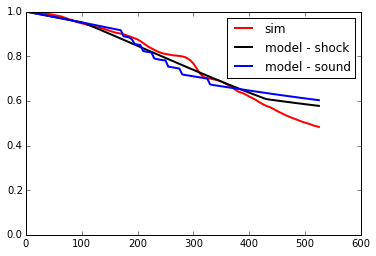

In [40]:
alpha_shock = best_alpha
beta_shock  = best_beta

alpha_sound = best_sound_alpha
beta_sound = best_sound_beta

m_shock = function_to_fit(adiabatic['t'],alpha_shock,beta_shock,anal_carina,method='shock')
m_sound = function_to_fit(adiabatic['t'],alpha_sound,beta_sound,anal_carina,method='sound')

error_shock = np.sum(((m_shock-adiabatic['m'])/adiabatic['m'][0])**2)
error_sound = np.sum(((m_sound-adiabatic['m'])/adiabatic['m'][0])**2)

plt.plot(adiabatic['t']/cgs.Myr, adiabatic['m']/adiabatic['m'][0],color='red',lw=2,label='sim')
plt.plot(adiabatic['t']/cgs.Myr, m_shock/m_shock[0] ,color='black',lw=2,label='model - shock')
plt.plot(adiabatic['t']/cgs.Myr, m_sound/m_sound[0] ,color='blue',lw=2,label='model - sound')

plt.ylim(0,1)
plt.legend(loc='best')

In [41]:
outfile.close()